# MNIST Binary Classification (from scratch)

In [1]:
%matplotlib inline
import numpy as np
import sys
import random as rd
import math
import matplotlib.pyplot as plt
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
from keras.datasets import mnist #keras has been used only to load the MNIST dataset

In [3]:
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# extract examples with y=0 or y=1
filter_train_set = np.where((train_Y==0) | (train_Y==1))[0]
filter_test_set = np.where((test_Y==0) | (test_Y==1))[0]

train_X, train_Y = train_X[filter_train_set], train_Y[filter_train_set]
test_X, test_Y = test_X[filter_test_set], test_Y[filter_test_set]

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(12665, 28, 28)
(12665,)
(2115, 28, 28)
(2115,)


In [5]:
train_X = (train_X.reshape((-1, 28*28))).T
train_Y = train_Y.reshape((1, len(train_Y)))
test_X = (test_X.reshape((-1, 28*28))).T
test_Y = test_Y.reshape((1, len(test_Y)))

print(f"train_X shape: {train_X.shape}")
print(f"train_Y shape: {train_Y.shape}")
print(f"test_X shape: {test_X.shape}")
print(f"test_Y shape: {test_Y.shape}")

train_X shape: (784, 12665)
train_Y shape: (1, 12665)
test_X shape: (784, 2115)
test_Y shape: (1, 2115)


In [6]:
def plot_images(set='train', enable_prediction=False):
    # plots 64 random examples along with the output label from the train/test set
    if set=='train':
        X = train_X
        Y = train_Y
    elif set=='test':
        X = test_X
        Y = test_Y
    fig, ax = plt.subplots(8, 8, figsize=(10,10))
    row, col = 0, 1
    for i in range(64):
        rand_n = rd.randrange(0, Y.shape[1])
        example = X[:, rand_n].reshape((28, 28))
        label = Y[:, rand_n][0]
        title_text = f"Label: {label}"
        if enable_prediction:
            pred = forward_pass(trained_parameters, X[:, rand_n])
            pred = ((pred>0.5).astype('int'))[0][0]
            title_text = f"({label}, {pred}*)"
        ax[row,col-1].imshow(example, cmap=plt.get_cmap('gray'))
        ax[row,col-1].set_title(title_text)
        ax[row,col-1].axis('off')
        col += 1
        if 8//col == 0:
            row += 1
            col = 1
    fig.tight_layout()

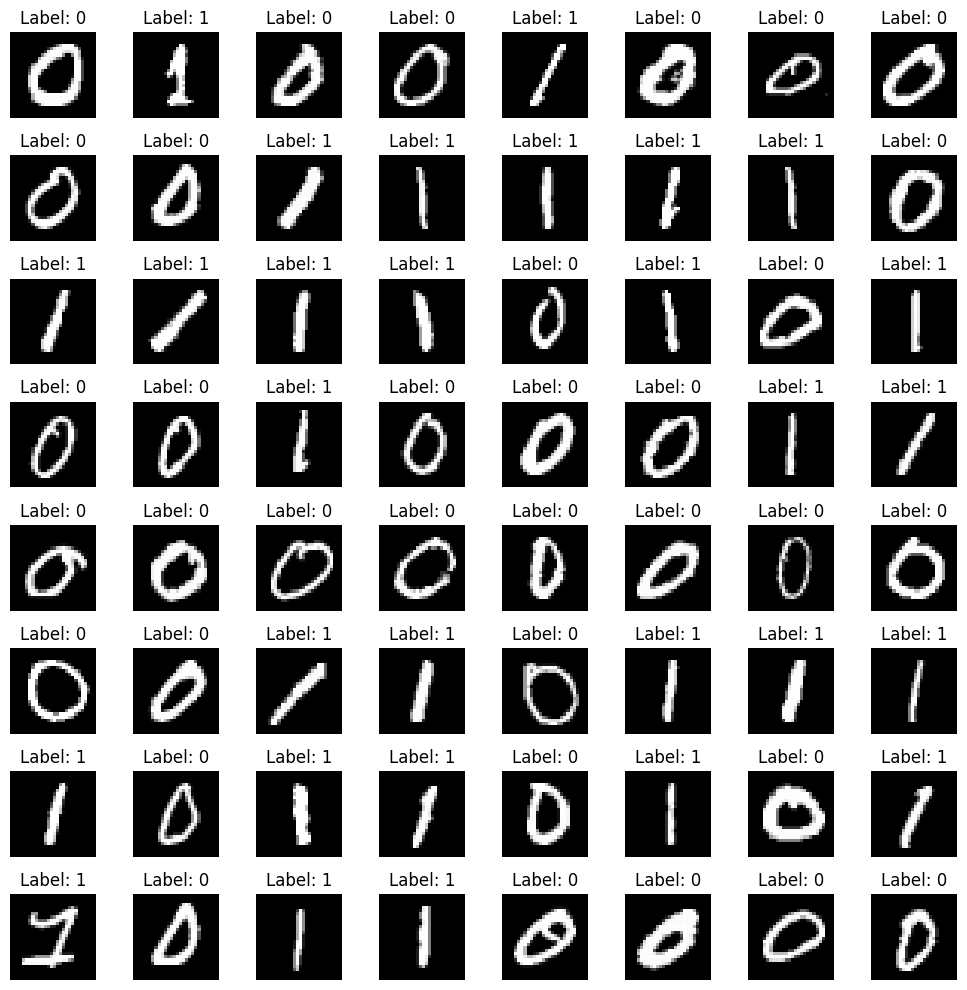

In [7]:
plot_images()

In [8]:
num_nodes = [128, 64, 10, 1] # [in layer 1, in layer 2, in layer 3, ..... so on]
layers = len(num_nodes)

In [9]:
def init_parameters(num_nodes):
    layers = len(num_nodes)
    num_nodes_mod = [train_X.shape[0]]
    num_nodes_mod.extend(num_nodes)
    parameters = {}
    for i in range(1, layers+1):
        W = np.random.uniform(-1., 1., size=(num_nodes_mod[i], num_nodes_mod[i-1]))/np.sqrt(num_nodes_mod[i]*num_nodes_mod[i-1])
        b = np.zeros((num_nodes_mod[i], 1))
        parameters['W'+str(i)] = W
        parameters['b'+str(i)] = b
        print(f"W{i} shape: {W.shape}")
        print(f"b{i} shape: {b.shape}")
    return parameters

In [10]:
init_param = init_parameters(num_nodes)

W1 shape: (128, 784)
b1 shape: (128, 1)
W2 shape: (64, 128)
b2 shape: (64, 1)
W3 shape: (10, 64)
b3 shape: (10, 1)
W4 shape: (1, 10)
b4 shape: (1, 1)


In [11]:
activations = ['relu', 'relu', 'relu', 'sigmoid'] 

In [12]:
def activation(Z, act, derivative):
    if act == 'relu':
        if not derivative:
            A = Z*((Z > 0).astype(int))
            return A
        else:
            d_Z = (Z>0).astype(int)
            return d_Z
    elif act == 'tanh':
        A = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))
        if not derivative:
            return A
        else:
            d_Z = 1 - A*A
            return d_Z
    elif act == 'sigmoid':
        A = 1/(1 + np.exp(-Z))
        if not derivative:
            return A
        else:
            d_Z = A*(1-A)
            return d_Z

In [13]:
def forward_pass(param, X=train_X, return_cache=False):
    if X.ndim == 1: #this happens when performing forward pass for a single example
        X = X.reshape((len(X), 1))
    cache = {'A0': X}
    layers = len(param)//2
    for i in range(1, layers+1):
        cache['Z'+str(i)] = param['W'+str(i)]@cache['A'+str(i-1)] + param['b'+str(i)]
        cache['A'+str(i)] = activation(cache['Z'+str(i)], activations[i-1], False)
    if return_cache:
        return cache
    else:
        return cache['A'+str(layers)]

In [14]:
def compute_cost_accuracy(param, set, print_opt=True):
    # set --> 'train'/'test'
    if set=='train':
        X = train_X
        Y = train_Y
    elif set=='test':
        X = test_X
        Y = test_Y
    m = Y.shape[1]
    Y_hat = forward_pass(param, X)
    
    Y_hat_thresh = ((Y_hat>0.5).astype('int')) #apply threshold
    corr_incorr = (Y_hat_thresh == Y)
    correct = np.sum(corr_incorr)
    incorrect = m - correct
    accuracy = (correct/m)*100
    
    cost = (-1/m)*np.sum(Y*np.log(Y_hat) + (1-Y)*np.log(1-Y_hat))

    if print_opt:
        print(f"Correct: {correct} | Incorrect: {incorrect}")
        print("Accuracy on %s set: %.2f" % (set, accuracy))
        print(f"Cost on {set} set: {cost}")
    else:
        return (accuracy, cost)

In [15]:
# initial cost and accuracy on the train set
compute_cost_accuracy(init_param, set='train')

Correct: 5845 | Incorrect: 6820
Accuracy on train set: 46.15
Cost on train set: 0.6938353922231033


In [16]:
#initial cost and accuracy on the test set
compute_cost_accuracy(init_param, set='test')

Correct: 973 | Incorrect: 1142
Accuracy on test set: 46.00
Cost on test set: 0.6938297538771243


In [17]:
def backward_pass(param, X, Y):
    if X.ndim == 1: X = X.reshape((len(X), 1))
    if Y.ndim == 1: Y = Y.reshape((len(Y), 1)) 
    layers = len(param)//2
    forward_cache = forward_pass(param, X, return_cache=True)
    derivatives = {}
    
    m = X.shape[1]
    A_L = forward_cache['A'+str(layers)]
    d_A = (1/m)*((1/(1-A_L))*(1-Y) - (1/A_L)*Y) #backward seed for binary classification
    for i in range(layers, 0, -1):
        Z = forward_cache['Z'+str(i)]
        A_prev = forward_cache['A'+str(i-1)]
        W = param['W'+str(i)]
        d_activation = activation(Z, activations[i-1], derivative=True)
        
        d_Z = d_A*d_activation
        d_W = d_Z@(A_prev.T)
        d_b = np.sum(d_Z, axis=1, keepdims=True)
        d_A = (W.T)@d_Z

        derivatives['d_W'+str(i)] = d_W
        derivatives['d_b'+str(i)] = d_b
    return derivatives

In [18]:
der_out = backward_pass(init_param, train_X, train_Y)
for i in range(1, layers+1):
    print(f"d_W{i} shape: {der_out['d_W'+str(i)].shape}")
    print(f"d_b{i} shape: {der_out['d_b'+str(i)].shape}")

d_W1 shape: (128, 784)
d_b1 shape: (128, 1)
d_W2 shape: (64, 128)
d_b2 shape: (64, 1)
d_W3 shape: (10, 64)
d_b3 shape: (10, 1)
d_W4 shape: (1, 10)
d_b4 shape: (1, 1)


In [19]:
def train(param, epochs, batch_size, alpha, beta1=0.9, beta2=0.999, E=1e-08, decay_rate=0):
    layers = len(param)//2
    if batch_size == -1:
        X_batch = train_X
        Y_batch = train_Y

    cost_hist = []
    accuracy_hist = []
    accuracy, cost = compute_cost_accuracy(param, 'train', print_opt=False)
    cost_hist.append(cost)
    accuracy_hist.append(accuracy)
    print("At epoch 0 --> Accuracy: %.2f | Cost: %s"%(accuracy, cost))

    train_param = param.copy()
    adam_cache = {}
    for i in range(1, layers+1): #initialize adam_cache
        adam_cache['V_W'+str(i)] = 0
        adam_cache['V_b'+str(i)] = 0
        adam_cache['S_W'+str(i)] = 0
        adam_cache['S_b'+str(i)] = 0

    for epoch in range(1, epochs+1):
        alpha_ = alpha/(1+(i*decay_rate))
        if batch_size != -1:
            batch_indices = rd.choices(list(range(train_X.shape[1])), k=batch_size)
            X_batch = train_X[:, batch_indices]
            Y_batch = train_Y[:, batch_indices]

        derivatives = backward_pass(train_param, X_batch, Y_batch)

        for i in range(layers, 0, -1):
            d_W = derivatives['d_W'+str(i)]
            d_b = derivatives['d_b'+str(i)]
            W = train_param['W'+str(i)]
            b = train_param['b'+str(i)]

            V_W = adam_cache['V_W'+str(i)]
            V_b = adam_cache['V_b'+str(i)]
            S_W = adam_cache['S_W'+str(i)]
            S_b = adam_cache['S_b'+str(i)]

            V_W = beta1*V_W + (1-beta1)*d_W
            V_b = beta1*V_b + (1-beta1)*d_b
            S_W = beta2*S_W + (1-beta2)*(d_W**2)
            S_b = beta2*S_b + (1-beta2)*(d_b**2)
            V_W_c, V_b_c = V_W/(1-beta1**epoch), V_b/(1-beta1**epoch)
            S_W_c, S_b_c = S_W/(1-beta2**epoch), S_b/(1-beta2**epoch)

            #update the parameters of ith layer
            W = W - ((alpha_/(np.sqrt(S_W_c)+E))*V_W_c)
            b = b - ((alpha_/(np.sqrt(S_b_c)+E))*V_b_c)

            #writing values back to the respective caches
            train_param['W'+str(i)] = W
            train_param['b'+str(i)] = b

            adam_cache['V_W'+str(i)] = V_W
            adam_cache['V_b'+str(i)] = V_b
            adam_cache['S_W'+str(i)] = S_W
            adam_cache['S_b'+str(i)] = S_b

        accuracy, cost = compute_cost_accuracy(train_param, 'train', print_opt=False)
        cost_hist.append(cost)
        accuracy_hist.append(accuracy)

        if epoch% math.ceil(epochs/10) == 0 or epoch == (epochs):
            print("At epoch %s --> Accuracy: %.2f | Cost: %s"%(epoch, accuracy, cost))

    return train_param, accuracy_hist, cost_hist

In [28]:
trained_parameters, accuracy_hist, cost_hist= train(init_param, 120, -1, 0.0007)

At epoch 0 --> Accuracy: 46.15 | Cost: 0.6938353922231033
At epoch 12 --> Accuracy: 99.76 | Cost: 0.009677682348225724
At epoch 24 --> Accuracy: 99.89 | Cost: 0.003785154030786277
At epoch 36 --> Accuracy: 99.94 | Cost: 0.0022251927461982963
At epoch 48 --> Accuracy: 99.97 | Cost: 0.001436833362433676
At epoch 60 --> Accuracy: 99.99 | Cost: 0.0009597479613586848
At epoch 72 --> Accuracy: 99.99 | Cost: 0.0006453549187805203
At epoch 84 --> Accuracy: 99.99 | Cost: 0.00037440291794934937
At epoch 96 --> Accuracy: 100.00 | Cost: 0.00020371612542742504
At epoch 108 --> Accuracy: 100.00 | Cost: 0.0001410596637545204
At epoch 120 --> Accuracy: 100.00 | Cost: 0.0001044205309501748


In [29]:
compute_cost_accuracy(trained_parameters, 'train')

Correct: 12665 | Incorrect: 0
Accuracy on train set: 100.00
Cost on train set: 0.0001044205309501748


In [30]:
compute_cost_accuracy(trained_parameters, 'test')

Correct: 2114 | Incorrect: 1
Accuracy on test set: 99.95
Cost on test set: 0.0029893575133943993


Text(0.5, 1.0, 'Epoch vs Cost')

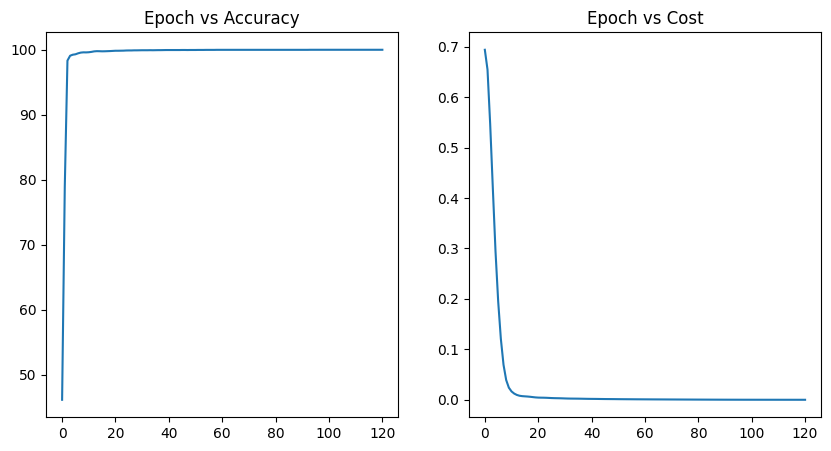

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(accuracy_hist)
ax[0].set_title('Epoch vs Accuracy')
ax[1].plot(cost_hist)
ax[1].set_title('Epoch vs Cost')

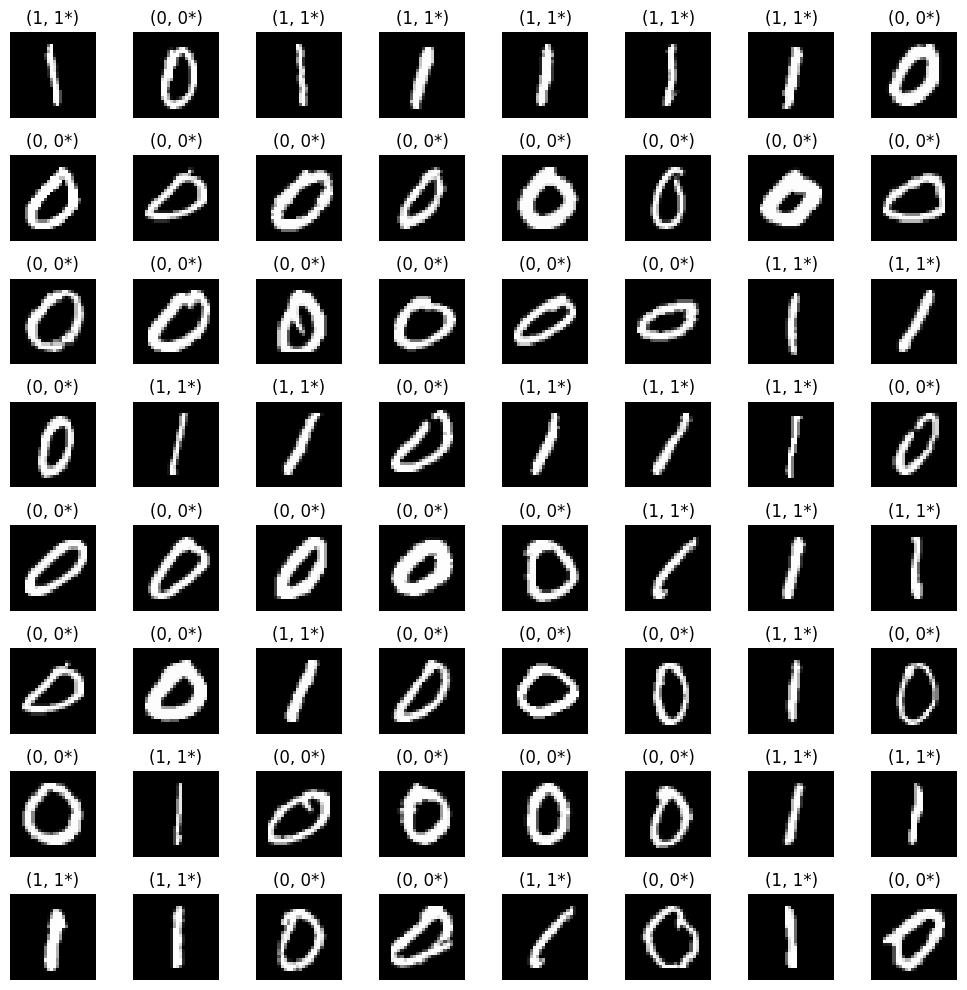

In [32]:
plot_images(set='test', enable_prediction=True) #64 items from the test set along with predictions

In [25]:
def plot_mislabeled(param):
    # plots mislabeled examples from the train and test sets
    train_pred = forward_pass(param, train_X, False)
    train_pred = (train_pred>0.5).astype('int')
    mislabeled_train = np.where(((train_pred != train_Y).astype('int')).reshape((train_Y.shape[1],))==1)[0]
    
    test_pred = forward_pass(param, test_X, False)
    test_pred = (test_pred>0.5).astype('int')
    mislabeled_test = np.where(((test_pred != test_Y).astype('int')).reshape((test_Y.shape[1],))==1)[0]
    total_mislabeled = len(mislabeled_train)+len(mislabeled_test)
    rows = math.ceil(total_mislabeled/4)
    if rows == 1:
        rows += 1
    fig, ax = plt.subplots(rows, 4, figsize=(8, rows*2))
    subplot_indices = []
    for j in range(rows):
        for k in range(4):
            subplot_indices.append((j, k))
            
    for i in range(len(subplot_indices)):
        row, col = subplot_indices[i]
        if i < len(mislabeled_train):
            plot_X = train_X[:, mislabeled_train[i]].reshape((28, 28))
            ax[row,col].imshow(plot_X, cmap=plt.get_cmap('gray'))
            ax[row,col].set_title('train')
        elif len(mislabeled_train) <= i < total_mislabeled:
            j = i - len(mislabeled_train)
            plot_X = test_X[:, mislabeled_test[j]].reshape((28, 28))
            ax[row,col].imshow(plot_X, cmap=plt.get_cmap('gray'))
            ax[row,col].set_title('test')
            
        ax[row,col].axis('off')

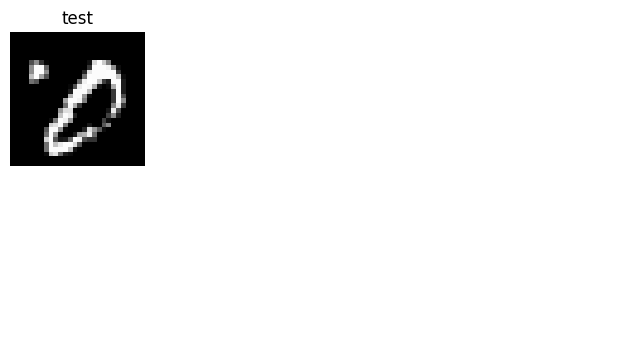

In [33]:
plot_mislabeled(trained_parameters)